In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_id, (example_data, example_targets) = next(examples)

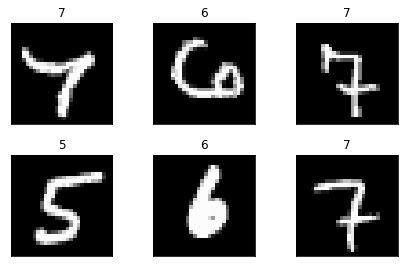

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [32]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First 2D convolutional layer, taking in 1 input channel (image),
      # outputting 10 convolutional features, with a square kernel size of 5
      self.conv1 = nn.Conv2d(1, 10, 5)
      # Second 2D convolutional layer, taking in the 10 input layers,
      # outputting 20 convolutional features, with a square kernel size of 3
      self.conv2 = nn.Conv2d(10, 20, 5)

        
      # Designed to ensure that adjacent pixels are either all 0s or all active
      # with an input probability
      self.conv2_drop = nn.Dropout2d()

      # First fully connected layer
      self.fc1 = nn.Linear(320, 50)
      # Second fully connected layer that outputs our 10 labels
      self.fc2 = nn.Linear(50, 10)
        # expected 5000 (50 * 10), 320
    
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [18]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [36]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#       torch.save(network.state_dict(), './results/model.pth')
#       torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [37]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/anaconda3/envs/data-visualization/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3055, Accuracy: 1287/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315726
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.323595
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.317707
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.318412
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.356097
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.369715
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.288597
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.347165
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.364356
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.351144
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.302477
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.319450
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.290553
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.265286
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.270542
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.301897
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.287222
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.334852
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.327018
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 2.288895
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.293000
Train Epoch: 2 [45440/60000 (76%)]	Loss: 2.344549
Train Epoch: 2 [46080/60000 (77%)]	Loss: 2.316699
Train Epoch: 2 [46720/60000 (78%)]	Loss: 2.276683
Train Epoch: 2 [47360/60000 (79%)]	Loss: 2.374560
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.281632
Train Epoch: 2 [48640/60000 (81%)]	Loss: 2.306222
Train Epoch: 2 [49280/60000 (82%)]	Loss: 2.299673
Train Epoch: 2 [49920/60000 (83%)]	Loss: 2.294724
Train Epoch: 2 [50560/60000 (84%)]	Loss: 2.298490
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.316360
Train Epoch: 2 [51840/60000 (86%)]	Loss: 2.346789
Train Epoch: 2 [52480/60000 (87%)]	Loss: 2.336747
Train Epoch: 2 [53120/60000 (88%)]	Loss: 2.328973
Train Epoch: 2 [53760/60000 (90%)]	Loss: 2.366712
Train Epoch: 2 [54400/60000 (91%)]	Loss: 2.334711
Train Epoch: 2 [55040/60000 (92%)]	Loss: 2.361502
Train Epoch: 2 [55680/60000 (93%)]	Loss: 2.325881
Train Epoch: 2 [56320/60000 (94%)]	Loss: 2.325577
